# Verhaltensweisen / Merkmale der Fahrgäste

Diese Datei enthält die Auswertung von Verhaltensweisen und Merkmalen.
1. Vorkommen der Verhaltensweisen und Merkmale an Türen 
2. Auswirkung der Verhaltensweisen und Merkmale auf die gesamte Fahrgastwechselzeit
3. Logistische Regession für das Vorkommen von Platzmachern.

## Bibliotheken

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

## Stildefinition für Plots

In [2]:
#Definierter Plotstyle für die Bachelorarbeit
#Muss zu den anderen Bibliotheken hinzugefügt werden
#Datei in Dateien eingefügt
plt.style.use('ba')

## Helferfunktionen

In [3]:
# Laden der Tabelle
def load_data(path):
    return pd.DataFrame(pd.read_csv(path+file_suffix, sep=";"))

# Helferfunktion für das zählen des Vorkommens von Verhaltensweisen/Merkmalen an Türen
# df ist Data series mit der Anzahl der Personen die eine Verhaltensweise in einem Video gezeigt haben
def door_count(df):
    count = 0
    for row in df:
        if row > 0:
            count += 1
    return count

# trimmt eine Dataframe, so das nur die Daten für die angegebene Personen im Frame ist
def trim_to_persons(df, persons, min_persons, max_persons):
    return df.where(persons >= min_persons).where(persons <= max_persons).dropna()

# Helferfunktionen für den Zusammenhang von Verhaltensweisen/Merkmalen und gesamten Fahrgastwechselzeiten

def box_plot_corr(persons, time, behav_series, name, min_persons, max_persons):
    plt.figure(figsize=(16, 8))
    
    time_behavior = time.where(behav_series>0)
    time_behavior = trim_to_persons(time_behavior, persons, min_persons, max_persons)

    persons_behavior = persons.where(behav_series>0)
    persons_behavior = trim_to_persons(persons_behavior, persons, min_persons, max_persons)
    
    time = time.where(behav_series<=0)
    time = trim_to_persons(time, persons, min_persons, max_persons)
    
    persons = persons.where(behav_series<=0)
    persons = trim_to_persons(persons, persons, min_persons, max_persons)
    
    time_per_person_behav = time_behavior/persons_behavior
    time_per_person = time/persons
    
    mean_behav = time_per_person_behav.mean()
    mean = time_per_person.mean()
    
    mean_text = "Mittelwert der Zeit pro Person"
    marker_size = 4
    
    plt.boxplot([time_per_person_behav, time_per_person], vert=0)
    
    plt.plot(mean_behav, 1, 'o', ms=marker_size, label=mean_text+" mit Verhalten: {:.2f}".format(mean_behav))
    plt.plot(mean, 2, 'o', ms=marker_size, label=mean_text+" ohne Verhalten: {:.2f}".format(mean))
    
    plt.legend()
    plt.yticks([1, 2], [name, 'ohne \nVerhalten/\nMerkmal'])
    plt.xlabel('Zeit pro Person (Fahrgastwechselzeit/Fahrgäste)')
    
    #Wegen Problemen beim laden mit Latex
    name = name.replace(' ','')
    name = name.replace('ü', 'ue')
    plt.savefig('..\\Text\\pictures\\data_evaluation\\behavior\\comp_'+name+'.png', bbox_inches='tight')
    
    plt.show()
    return time_per_person, time_per_person_behav

# Helferfunktionen für die logitsische Regression

def logit(x, a, b):
    z = np.exp(a + b * x)
    return z / (1 + z)

def plot_conf_int(confidence_intervall, function, x, alpha=.05, color='black'):
    confidence_intervall = np.array(confidence_intervall)
    x_max = np.max([function(x, confidence_intervall[0,0], confidence_intervall[1,0]),
                    function(x, confidence_intervall[0,1], confidence_intervall[1,1]),
                    function(x, confidence_intervall[0,0], confidence_intervall[1,1]),
                    function(x, confidence_intervall[0,1], confidence_intervall[1,0])], axis=0)
    x_min = np.min([function(x, confidence_intervall[0,0], confidence_intervall[1,0]),
                    function(x, confidence_intervall[0,1], confidence_intervall[1,1]),
                    function(x, confidence_intervall[0,0], confidence_intervall[1,1]),
                    function(x, confidence_intervall[0,1], confidence_intervall[1,0])], axis=0)
    plt.fill_between(x, x_max, x_min, alpha=.1, color=color, label='Konfidenzintervall')
    return 

# Laden der Daten

In [4]:
path = "Tabels/Behaviors"
file_suffix = ".csv"

In [5]:
data = load_data(path)
#data

## Vorkommen von Verhaltensweisen/Merkmalen an Türen

In [6]:
#Prozesstypen
# Namen der Verhaltensweisen 
behav = ["spacemaker", "boarding early", "in way", "bulky", "slow", "distracted"]

dic_door_counts = {}

for behavior in behav:
    dic_door_counts[behavior] = door_count(data[behavior])


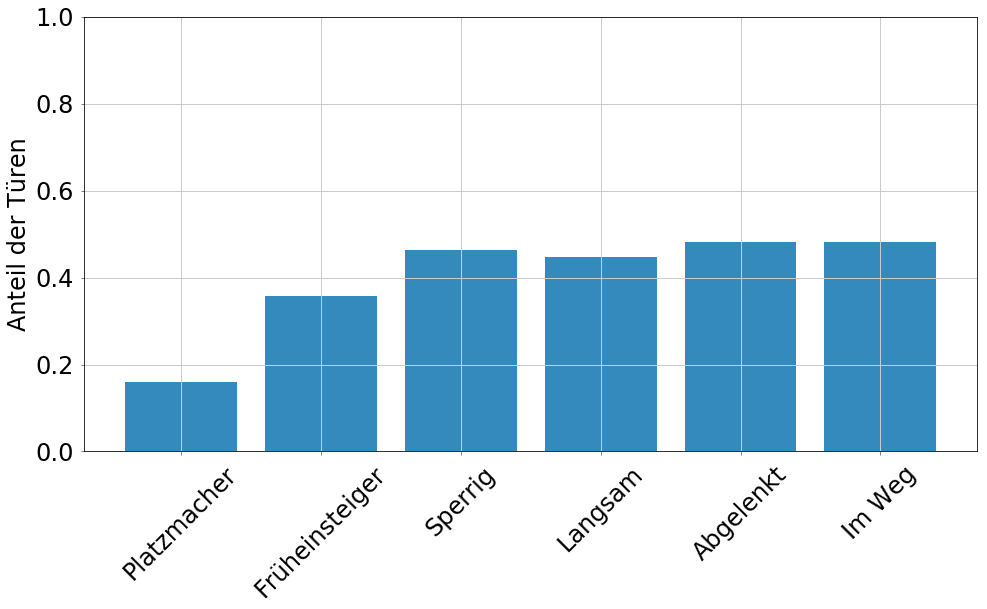

In [7]:
# Deutsche Namen der Verhaltensweisen/Merkmale
objects = ['Platzmacher', 'Früheinsteiger', 'Sperrig', 'Langsam', 'Abgelenkt', 'Im Weg']

plt.figure(figsize=(16, 8))
y_pos = np.arange(len(objects))
plt.bar(y_pos, [dic_door_counts['spacemaker']/len(data), 
                dic_door_counts['boarding early']/len(data), 
                dic_door_counts['bulky']/len(data), 
                dic_door_counts["slow"]/len(data), 
                dic_door_counts['distracted']/len(data), 
                dic_door_counts['in way']/len(data)])
plt.xticks(y_pos, objects, rotation=45)
plt.ylim(0, 1)
plt.ylabel('Anteil der Türen')
plt.savefig('..\\Text\\pictures\\data_evaluation\\behavior\\counts_behavoirs.png', bbox_inches='tight')
plt.show()

In [8]:
# Anteil der Platzmacher an Türen
prop_spacemaker = dic_door_counts["spacemaker"]/len(data)
print("Anteil Platzmacher {:.2f}".format(prop_spacemaker*100))

prop_bulky = data["bulky"]/(data["alight"]+data["boarding"]+data["spacemaker"])
print("Mittelwert des Anteils an Sperrigen Personen pro Tür {:.2f} %".format(prop_bulky.mean()*100))

print("Anteil der Türen an denen sperrige Personen auftreten {:.2f} %".format((dic_door_counts['bulky']/len(data))*100))

Anteil Platzmacher 16.07
Mittelwert des Anteils an Sperrigen Personen pro Tür 4.05 %
Anteil der Türen an denen sperrige Personen auftreten 46.43 %


## Auswirkung der Verhaltensweisen/Merkmale auf die gesamte Fahrgastwechselzeit
1. Langsame
2. Sperrige
3. Abgelenkte
4. Früher Einsteiger
5. Im Weg

In [9]:
persons = data['alight']+data['boarding']+2*data['spacemaker']
time = data['time']
time_per_person = persons/time

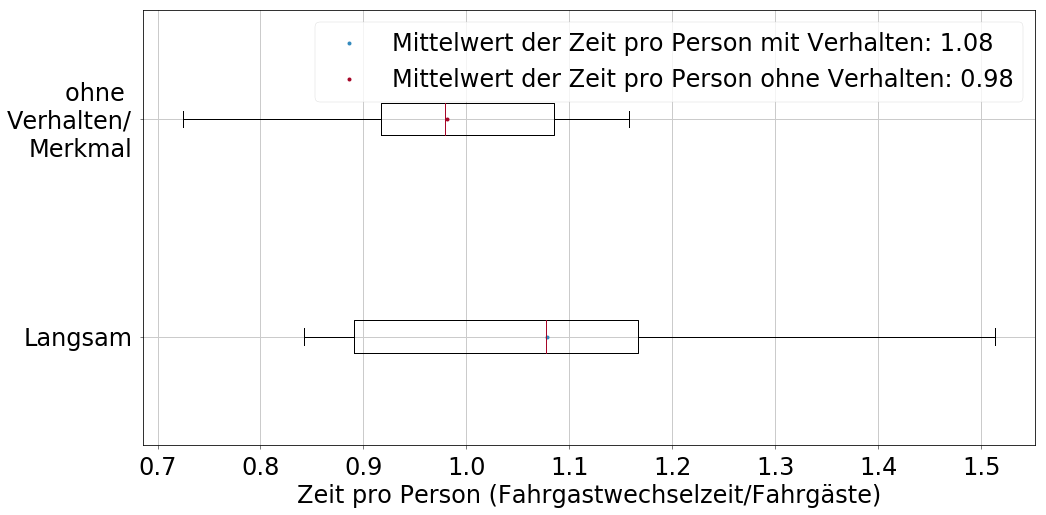

Median der Zeit pro Person mit Verhalten 1.078
75% Quantil der Zeit pro Person ohne Verhalten 1.086


In [10]:
t_per_person, t_per_person_behav = box_plot_corr(persons, time, data['slow'], "Langsam", 10, 16)
print("Median der Zeit pro Person mit Verhalten {:.3f}".format(t_per_person_behav.median()))
print("75% Quantil der Zeit pro Person ohne Verhalten {:.3f}".format(t_per_person.quantile(0.75)))

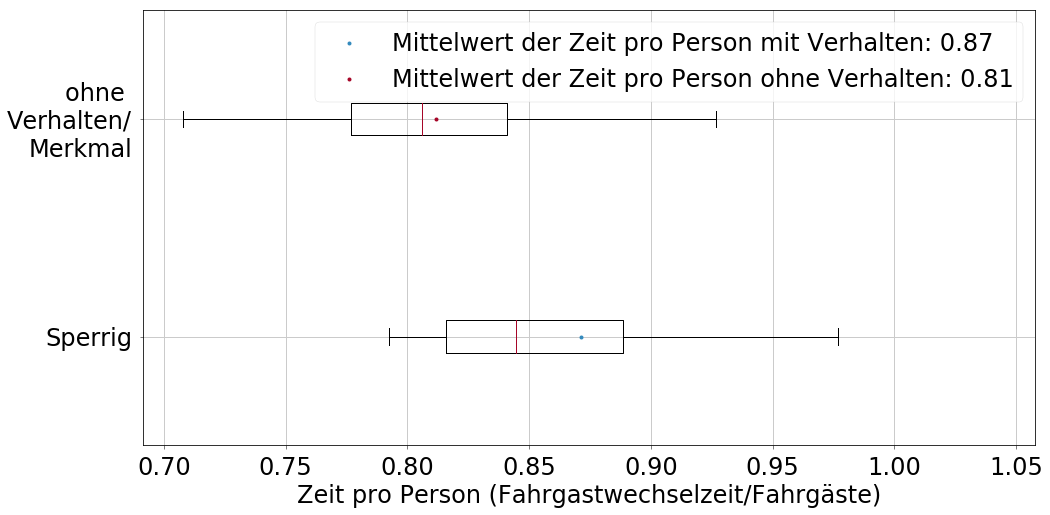

Median der Zeit pro Person mit Verhalten 0.844
75% Quantil der Zeit pro Person ohne Verhalten 0.841


In [11]:
t_per_person, t_per_person_behav = box_plot_corr(persons, time, data["bulky"], 'Sperrig', 20, 27)
print("Median der Zeit pro Person mit Verhalten {:.3f}".format(t_per_person_behav.median()))
print("75% Quantil der Zeit pro Person ohne Verhalten {:.3f}".format(t_per_person.quantile(0.75)))

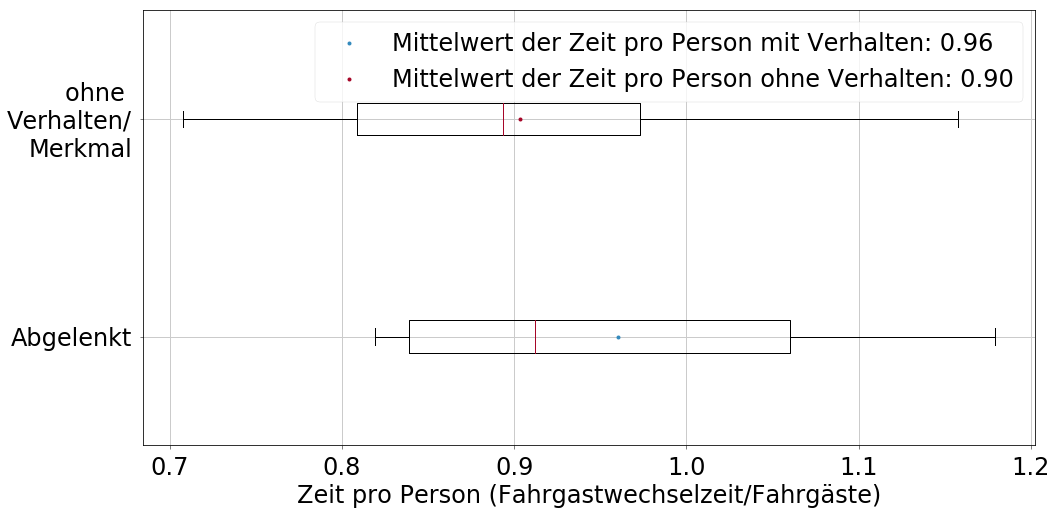

Median der Zeit pro Person mit Verhalten 0.912
75% Quantil der Zeit pro Person ohne Verhalten 0.973


In [12]:
t_per_person, t_per_person_behav = box_plot_corr(persons, time, data["distracted"], 'Abgelenkt', 13, 21)
print("Median der Zeit pro Person mit Verhalten {:.3f}".format(t_per_person_behav.median()))
print("75% Quantil der Zeit pro Person ohne Verhalten {:.3f}".format(t_per_person.quantile(0.75)))

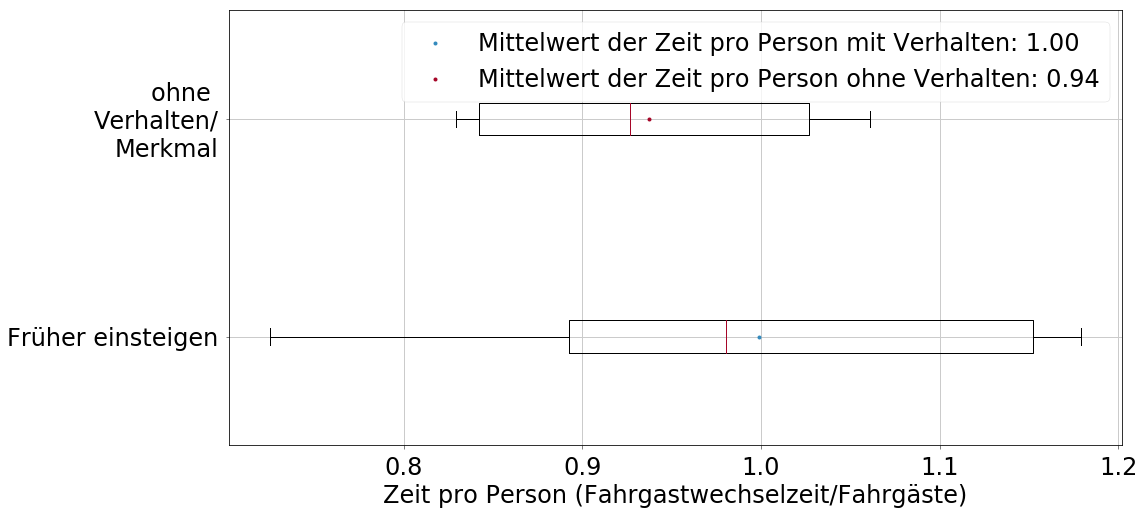

Median der Zeit pro Person mit Verhalten 0.980
75% Quantil der Zeit pro Person ohne Verhalten 1.027


In [13]:
t_per_person, t_per_person_behav = box_plot_corr(persons, time, data["boarding early"], 'Früher einsteigen', 12, 20)
print("Median der Zeit pro Person mit Verhalten {:.3f}".format(t_per_person_behav.median()))
print("75% Quantil der Zeit pro Person ohne Verhalten {:.3f}".format(t_per_person.quantile(0.75)))

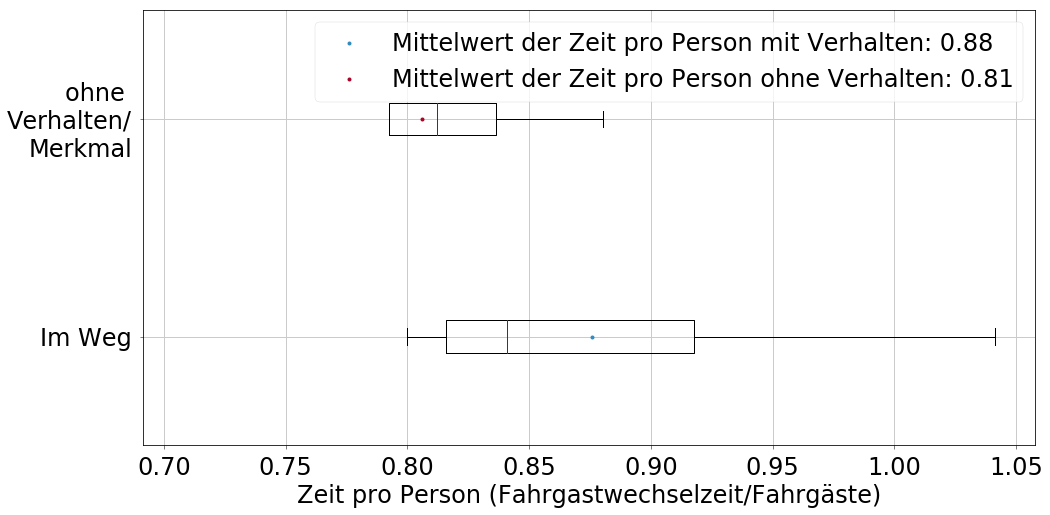

Median der Zeit pro Person mit Verhalten 0.841
75% Quantil der Zeit pro Person ohne Verhalten 0.836


In [14]:
t_per_person, t_per_person_behav = box_plot_corr(persons, time, data["in way"], 'Im Weg', 19, 27)
print("Median der Zeit pro Person mit Verhalten {:.3f}".format(t_per_person_behav.median()))
print("75% Quantil der Zeit pro Person ohne Verhalten {:.3f}".format(t_per_person.quantile(0.75)))

## Logistische Regression für das Vorkommen von Platzmachern
Im Verhältniss zu allen Personen die ein- und aussteigen.

In [15]:
alight = data["alight"]
cod_spacemaker = [1 if (i > 0) else 0 for i in data['spacemaker']]

Optimization terminated successfully.
         Current function value: 0.405828
         Iterations 6
confidence intervalls: 
                0         1
const  -4.613683 -1.313994
alight -0.001818  0.188815


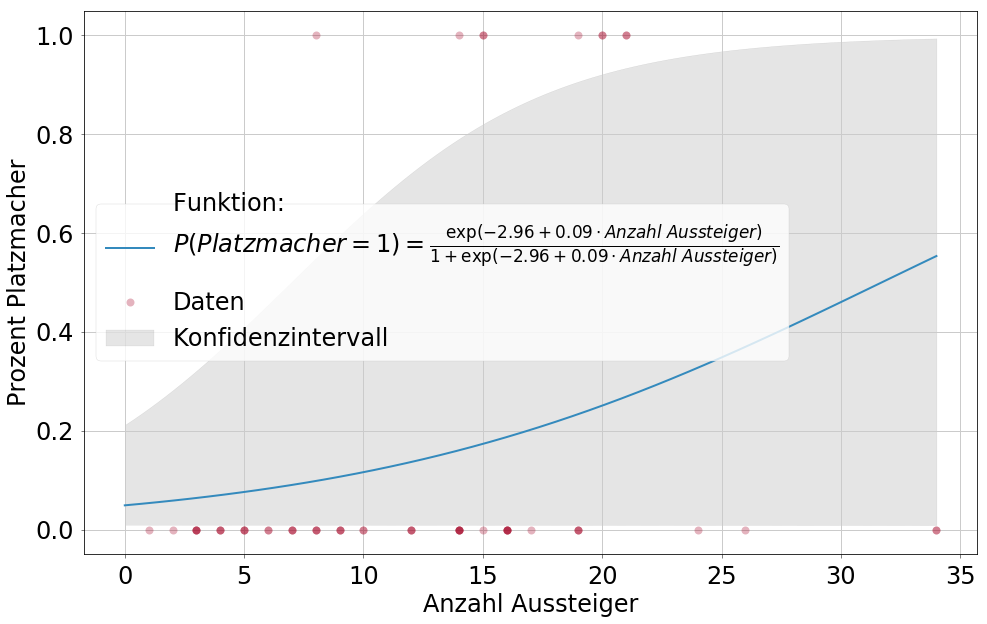

R^2 = 0.08
p-value t-Test of const 4e-04
p-value t-Test of alight 0.05


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:                          Logit   Df Residuals:                       54
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Aug 2019   Pseudo R-squ.:                 0.07945
Time:                        07:09:03   Log-Likelihood:                -22.726
converged:                       True   LL-Null:                       -24.688
                                        LLR p-value:                   0.04764
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9638      0.842     -3.521      0.000      -4.614      -1.314
alight         0.0935      0.049      1.923      0.055      -0.002       0.189
==============================================================================
"""

In [16]:
constant = add_constant(alight)
log_reg_spacemaker = Logit(cod_spacemaker, constant).fit()
print('confidence intervalls: \n', log_reg_spacemaker.conf_int())

n_i = "\exp({0:.2f}+ {1:.2f} \cdot Anzahl \ Aussteiger)".format(log_reg_spacemaker.params['const'], log_reg_spacemaker.params['alight'])
f = "$=\\frac{"+n_i+"}{1+"+n_i+"}$"
funktion = "$P(Platzmacher=1) $"+f

plt.figure(figsize=(16,10))
toPredict = np.linspace(0, max(alight))
predictedPoints = log_reg_spacemaker.predict(add_constant(toPredict))

plt.plot(toPredict, predictedPoints, label="Funktion: \n"+funktion)
plt.plot(alight, cod_spacemaker, 'o', label = 'Daten', alpha=0.3)

#Plotten des Konfidenzintervals
plot_conf_int(log_reg_spacemaker.conf_int(), logit, 
              np.linspace(0, max(alight), 100), alpha=.05)
plt.legend()
plt.xlabel('Anzahl Aussteiger')
plt.ylabel('Prozent Platzmacher')
plt.savefig("..\\Text\\pictures\\data_evaluation\\behavior\\log_reg_spacemaker.png")
plt.show()

print("R^2 = {:.2f}".format(log_reg_spacemaker.prsquared))
print("p-value t-Test of const {:.0e}".format(log_reg_spacemaker.pvalues['const']))
print("p-value t-Test of alight {:.2f}".format(log_reg_spacemaker.pvalues['alight']))
log_reg_spacemaker.summary()